## Wikipedia Page View Retrieval and Digital Data Comparisons

### Pageview Retrieval

In [1]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
import requests
import bs4
from bs4 import BeautifulSoup
import re

from requests.structures import CaseInsensitiveDict
#from ratelimit import limits, RateLimitException, sleep_and_retry
# pip install ratelimit

In [3]:
# Read in speciesinfo CSV
species = pd.read_csv("csv/speciesinfo.csv", sep = ";")
species.drop_duplicates(inplace = True)
species = species.reset_index(drop = True)
len(species)

561

## Wikipedia API

In [ ]:
# pip3 install wikipedia-api
import wikipediaapi
# only english language pages
api = wikipediaapi.Wikipedia('en')

wikiurls = []
# loop through the unique species names
for name in species['scientific_name'].unique():
    # Spaces to be replaced with underscore for Wiki's API
    name = name.replace(" ", "_")
    # retrieve each species' page, will redirect when called with scientifc name
    p = api.page(name)
    try:
        # Fullurl will contain the title of the species' wiki article
        data = {'url': p.fullurl, 'scientific_name': name}
        wikiurls.append(data)
    # species did not return with a valid url, no page exists for the species
    except KeyError:
        pass
    
# investigate how many species left   
len(wikiurls)

In [31]:
def WikiPageView(title):
    """
    Function to call Wikipedia's Pageview API
    
    Parameters: string
    
    """
    
    # Calling monthly page views of each species from 2015-2020
    address = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/" + title + "/monthly/2015010100/2020123100"

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    # Personal username for identification for the Wikipedia API
    headers = {'User-Agent': 'reddalisa/3.10.6 (alisa.redding@helsinki.fi)'}
    
    resp = requests.get(address, headers=headers)
    details = resp.json()
    
    return details 
      
    
# Create an empty list to store the pageviews results into
newframe = []  

# loop over the urls to extract the titles of the wikipages
for n in range(len(wikiurls)):
    name = wikiurls[n]['url'].removeprefix("https://en.wikipedia.org/wiki/")
    # using the extracted name, run through the function
    result = WikiPageView(name)
    sci_name = wikiurls[n]['scientific_name']
    
    try:
        # loop over the json results to store the relevant information 
        for n in range(len(result['items'])):
            title = result['items'][n]['article']
            date = result['items'][n]['timestamp']
            # Remove 00 at end of date string that is marking the hour
            date = date[:-2]
            view = result['items'][n]['views']
            
            # create a dictionary object 
            data = {'title': title, 'date': date, 'views': view, 'scientific_name' : sci_name}
            newframe.append(data)
    # Some pages have not been incorporated into the PageViews API yet, they will be passed
    except KeyError:
        pass



In [37]:
# Create a dataframe from the list
#wikipage = pd.DataFrame(newframe)
#wikipage["datetime"] = wikipage["date"].apply(pd.to_datetime)
wikipage = wikipage.drop(columns = 'date')
wikipage['title'] = wikipage["title"].apply(lambda x: x.replace("_", " "))
wikipage['scientific_name'] = wikipage["scientific_name"].apply(lambda x: x.replace("_", " "))
#len(wikipage['name'].unique())

In [48]:
# view highest view count
wikipage.sort_values(by="views", ascending = False)

,title,views,scientific_name,datetime
2762,Tiger,694465,Panthera tigris,2020-03-01
9262,Red panda,652891,Ailurus fulgens,2017-05-01
614,Lion,574872,Panthera leo,2017-03-01
650,Lion,574083,Panthera leo,2020-03-01
2763,Tiger,540666,Panthera tigris,2020-04-01
...,...,...,...,...
34056,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-07-01
34057,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-08-01
34058,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-09-01
34059,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-10-01


In [46]:
speciesinfo = pd.merge(species, wikipage.groupby('scientific_name')['views'].sum().reset_index(), on='scientific_name', how = 'inner').drop_duplicates()

In [47]:
speciesinfo.to_csv("csv/fullspeciesinfo.csv", sep = ";", index = False)

In [52]:
wikipage.to_csv("csv/wikipageviews.csv", sep = ";", index = False)

## Temporal Visualization & WordCloud

### Articles: Facebook shares

In [148]:
articles = pd.read_csv("articles-w-full_engagement.csv", sep = "~")
undoc = pd.read_csv("csv/undoc_species_articles.csv", sep = ";")
speciesinfo = pd.read_csv("csv/fullspeciesinfo.csv", sep = ";")

In [149]:
speciesinfo = pd.merge(speciesinfo, wiki[['scientific_name', 'title']], on='scientific_name', how='right').drop_duplicates().reset_index(drop=True)

In [150]:
# Simplify the IUCN categories
articles["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC", "Lower Risk/conservation dependent": "LC",
                                "Vulnerable" : "VU", "Near Threatened" : "NT", "Critically Endangered" : "CR",
                          "Extinct in the Wild" : "EW", "Endangered" : "EN", "Data Deficient" : "DD", 
                          "Extinct" : "EX"}, inplace=True)

In [151]:
articles = pd.merge(articles, speciesinfo, on = "scientific_name", how = "left")

In [152]:
# Only keep articles with shares
shared = articles.loc[articles['shares'] > 0].reset_index(drop = True)

# Define a binary classification in a new column for popularity
shared['Popular'] = 0

# Loop over the values in the shares column and if above the median classify as popular
for x in shared["shares"]:
    if x > shared["shares"].mean():
        shared.loc[shared['shares'] == x, 'Popular'] = 1

In [35]:
from PIL import Image 

pangolin_mask = np.array(Image.open("figures/pangolin_silhouette.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
# Transform your mask into a new one that will work with the function:
transformed_mask = np.ndarray((pangolin_mask.shape[0],pangolin_mask.shape[1]), np.int32)

for i in range(len(pangolin_mask)):
    transformed_mask[i] = list(map(transform_format, pangolin_mask[i]))

There are 1117 words in the combination of all cells in column title.


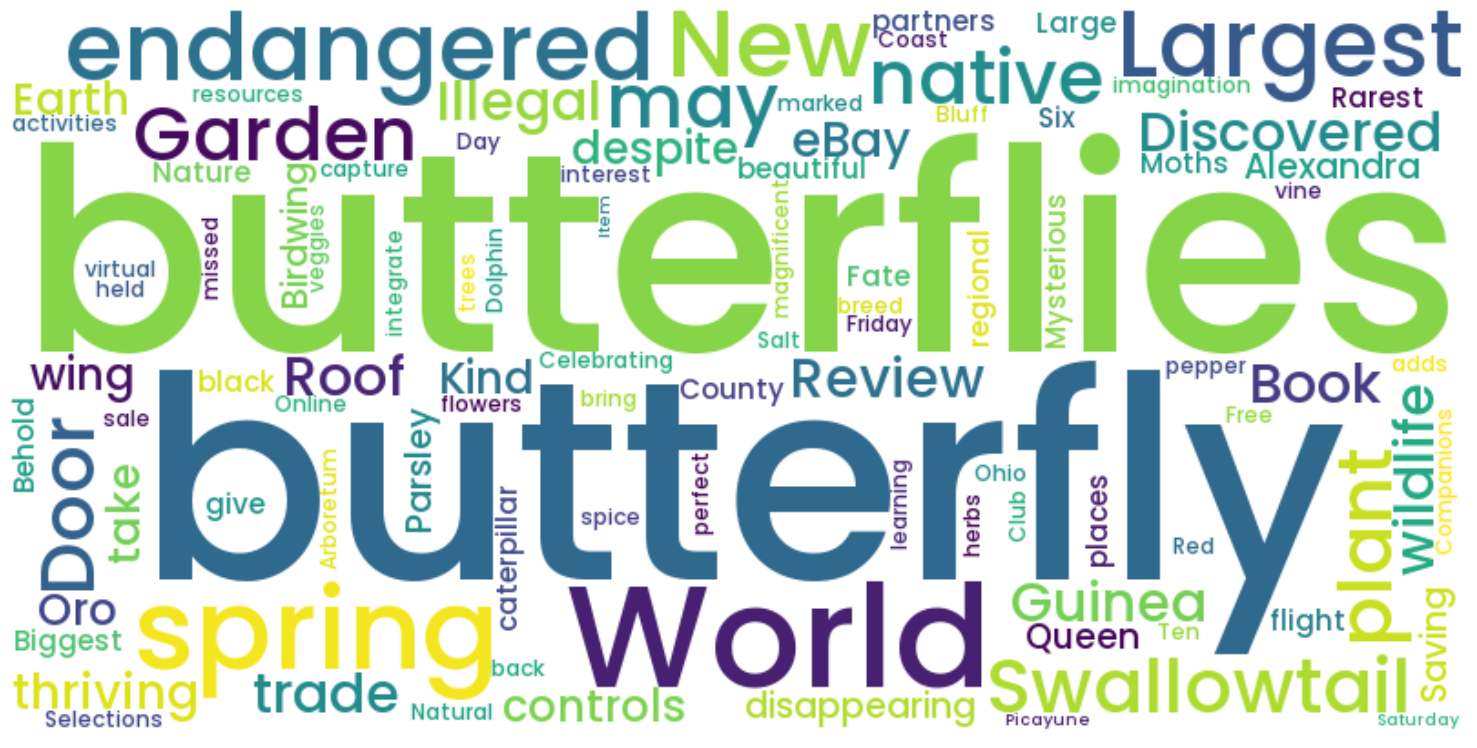

In [74]:
from wordcloud import WordCloud #pip install wordcloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Articles with greater than the avergae amount of shares in the dataset
popular = shared.loc[shared['Popular'] == 1]
# Articles with greater than 10,000 shares on Facebook (23 articles)
above10thou = articles.loc[articles['shares'] > 10000].reset_index(drop = True)

# Change to choose a certain IUCN status to display
critical = articles.loc[articles['iucn_status'] == "CR"].reset_index(drop = True)
# PLant kingdom articles
plants = articles.loc[articles['Kingdom'] == "Plantae"].reset_index(drop = True)
# Animal kingdom articles
animals = articles.loc[articles['Kingdom'] == "Animalia"].reset_index(drop = True)
# Bird articles
birds = articles.loc[articles['Class'] == "Aves"].reset_index(drop = True)
# Mammal articles
mammals = articles.loc[articles['Class'] == "Mammalia"].reset_index(drop = True)
# Reptile articles
reptiles = articles.loc[articles['Class'] == "Reptilia"].reset_index(drop = True)
amphibia = articles.loc[articles['Class'] == "Amphibia"].reset_index(drop = True)
insects = articles.loc[articles['Class'] == "Insecta"].reset_index(drop = True)
pangolins = articles.loc[articles['Order'] == "Pholidota"].reset_index(drop = True)
# UNDOC's species to watch for illegal trade
undoc = undoc.dropna(subset = ['title'])

# Change to title or text
text = " ".join(i for i in insects.title)
print ("There are {} words in the combination of all cells in column title.".format(len(text))) 

stopwords = set(STOPWORDS)
stopwords.update(["Animal", "animal", "Animals", "species", "s"])
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      font_path='fonts/Poppins-Medium.ttf',
                      width=800, 
                      height=400, 
                      #mask=transformed_mask, 
                      #contour_width=1, 
                      #contour_color='green'
                      ).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

wordcloud.to_file("figures/wordcloud_insects.png")

In [153]:
articles = articles.drop(columns = ["date_saved", "sharecount_x", "sharecount_y"])
articles['date'] = pd.to_datetime(articles['date'])

In [125]:
articleshares = articles.groupby([(articles.date.dt.year), (articles.date.dt.month), (articles.scientific_name)])['shares'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

ar16 = articleshares.loc[articleshares['Year'].isin([2016])]
chosen = ar16.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar16 = ar16.loc[ar16['scientific_name'].isin(chosen)]

ar17 = articleshares.loc[articleshares['Year'].isin([2017])]
chosen = ar17.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar17 = ar17.loc[ar17['scientific_name'].isin(chosen)]

ar18 = articleshares.loc[articleshares['Year'].isin([2018])]
chosen = ar18.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar18 = ar18.loc[ar18['scientific_name'].isin(chosen)]

ar19 = articleshares.loc[articleshares['Year'].isin([2019])]
chosen = ar19.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar19 = ar19.loc[ar19['scientific_name'].isin(chosen)]

ar20 = articleshares.loc[articleshares['Year'].isin([2020])]
chosen = ar20.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar20 = ar20.loc[ar20['scientific_name'].isin(chosen)]

In [154]:
#Isolating top 20 most shared species' articles 

shared = articles.groupby('scientific_name')['shares'].sum().nlargest(20).reset_index()#['scientific_name'].values.tolist()
#articspan = articles.loc[articles['scientific_name'].isin(shared)]
#articspan = articles.loc[articles.date.dt.year > 2015]
#articspan = articspan.reset_index(drop = True)

#shared = shared.drop(columns = ["sharecount"])
shared = pd.merge(shared, speciesinfo, on = "scientific_name", how = "left")
#shared = shared.drop(columns = ["sharecount"])


In [229]:
titles = articles.groupby(['scientific_name', 'title_y', 'title_x'])['shares'].sum().nlargest(10).reset_index()

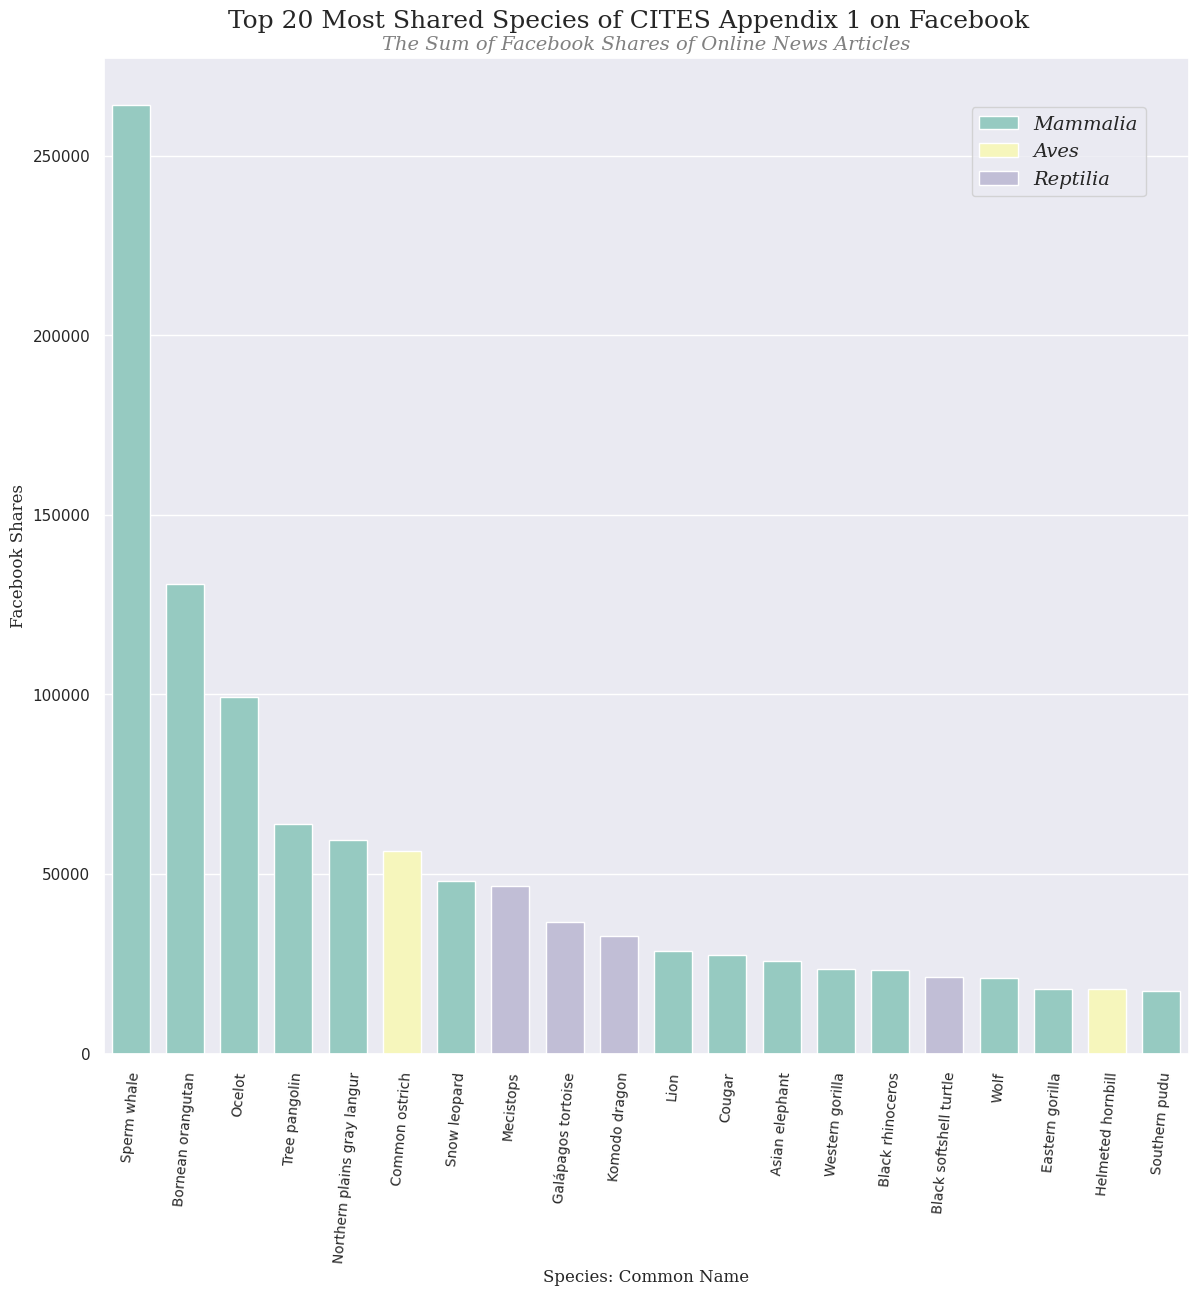

In [245]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})

palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}
plt.rcParams["axes.grid.axis"] ="y"

ax = sns.barplot(
    x = 'title',
    y = 'shares',
    hue = 'Class',
    data = shared, 
    width = 0.7, palette = palette, dodge = False
)
ax.set_xlabel('Species: Common Name', fontsize=12, family = "Serif")
ax.set_ylabel('Facebook Shares', fontsize=12, family = "Serif")


# Add suptitle above the title
plt.suptitle("Top 20 Most Shared Species of CITES Appendix 1 on Facebook\n", fontsize=18, family= 'Serif')
plt.subplots_adjust(top=0.94)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('The Sum of Facebook Shares of Online News Articles', fontsize = 14, color="grey", style='italic', family = 'Serif')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 10, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/top_20_species_fb.png', bbox_inches = 'tight')

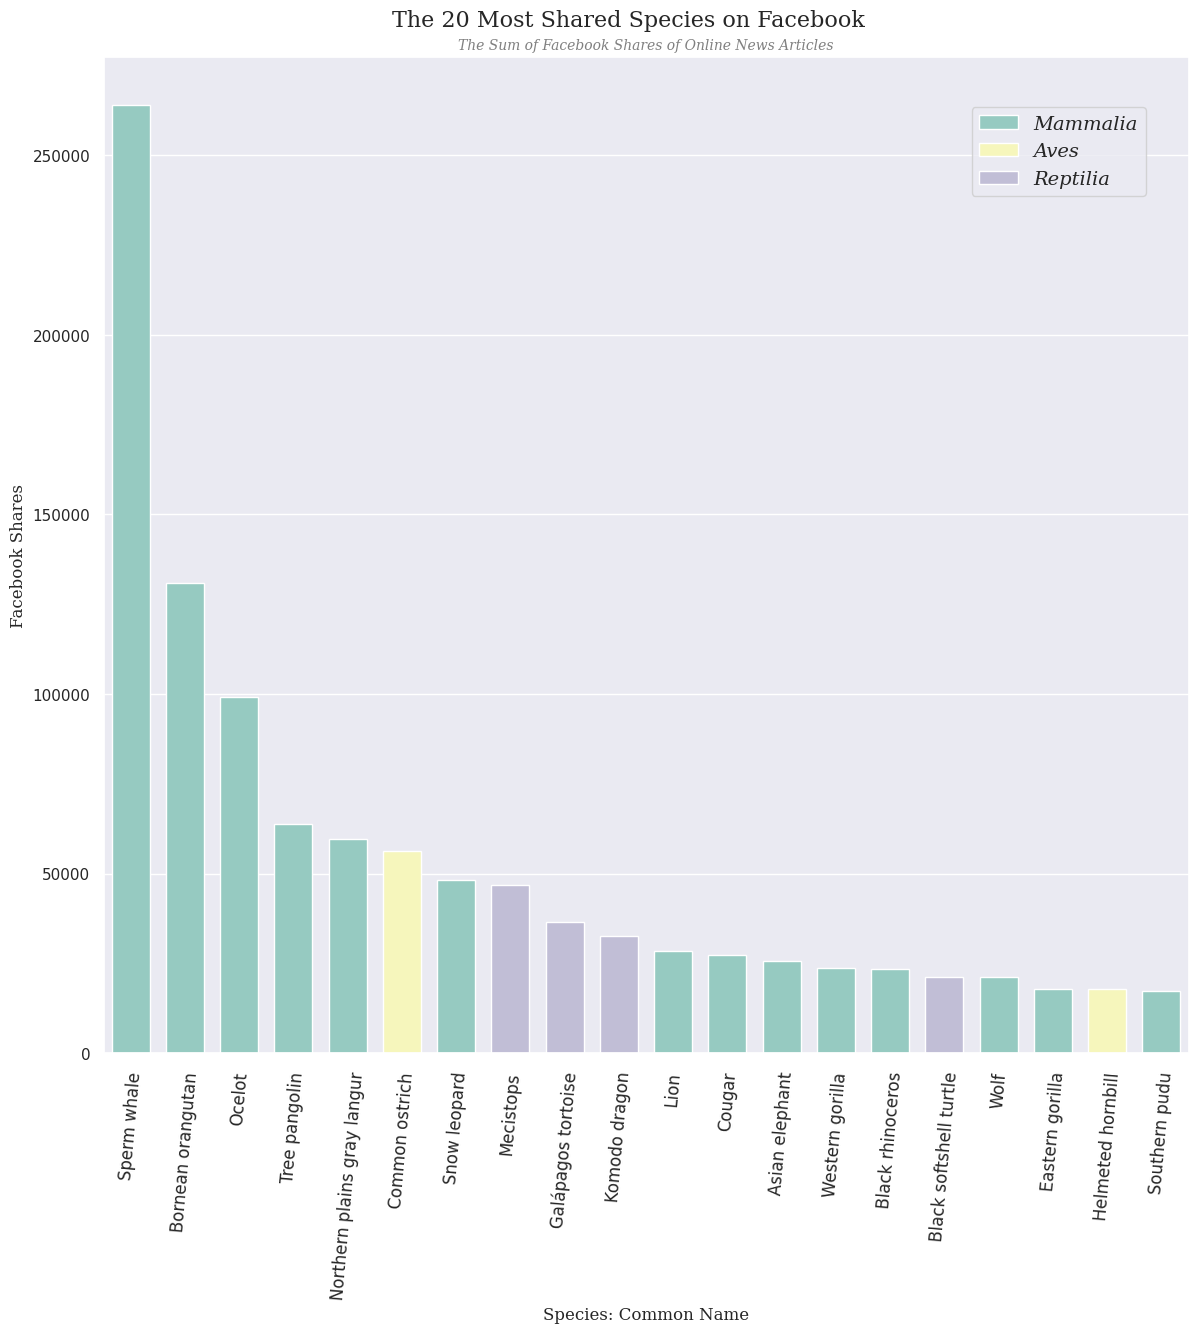

In [243]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})
plt.rcParams["axes.grid.axis"] ="y"

#plt.rcParams["axes.axisbelow"] = "line"


#palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}
#label_dict = {"Mammalia": "Mammalia", "Reptilia":"Reptilia", "Aves":"Aves"}
# Define fontstyle for legend
label_font = {'family': 'serif',
              'size': 12,
              'weight': 'italic'}


ax = sns.barplot(
    x = 'title', 
    y = 'shares',
    hue = 'Class',
    data = shared,
    width = 0.7,
    #marker = "o", 
    palette = "Set3",
    dodge = False)


ax.set_ylabel('Facebook Shares', fontsize=12, family = "Serif")
ax.set_xlabel('Species: Common Name', fontsize=12, family = "Serif")
#ax.set_yscale('log')

# Add suptitle above the title
plt.suptitle("The 20 Most Shared Species on Facebook\n", fontsize=16, family = 'Serif')
plt.subplots_adjust(top=0.94)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('The Sum of Facebook Shares of Online News Articles', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                  weight='regular',
                                  style='italic', size=14)

#font = {'family': 'Serif',
       # 'color':  'k',
        #'weight': 'normal',
        #'style':'italic',
        #'size': 9}

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#ax.set_yticklabels(titles['title_x'], horizontalalignment = "left", fontdict = font)
#ax.tick_params(axis='y', direction = "in", pad = -15)
ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 12, left = True)
#plt.rcParams["axes.grid.axis"] ="x"

# Customize the legend
#handles, labels = plt.gca().get_legend_handles_labels()
#ax.legend(handles, labels, bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
#plt.savefig('figures/facebook_sharedspecies.png', bbox_inches = 'tight')

### Wikipedia Pageviews

In [4]:
wiki = pd.read_csv("csv/wikipageviews.csv", sep = ";")

In [13]:
wiki = pd.merge(wiki, species[['scientific_name', 'Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species']], on = "scientific_name", how='left')

In [5]:
wiki["datetime"] = pd.to_datetime(wiki['datetime'])

In [6]:
temporal_wiki = wiki.groupby([(wiki.datetime.dt.year), (wiki.datetime.dt.month), (wiki.scientific_name)])['views'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

In [7]:
# Finding 5 most popular species of each year and plot their popularity over the year
yr20 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])]
chosen20 = yr20.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen20 = chosen20['scientific_name'].values.tolist()
yr20 = yr20.loc[yr20['scientific_name'].isin(chosen20)]

yr19 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])]
chosen19 = yr19.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen19 = chosen19['scientific_name'].values.tolist()
yr19 = yr19.loc[yr19['scientific_name'].isin(chosen19)]

yr18 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])]
chosen18 = yr18.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen18 = chosen18['scientific_name'].values.tolist()
yr18 = yr18.loc[yr18['scientific_name'].isin(chosen18)]

yr17 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])]
chosen17 = yr17.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen17 = chosen17['scientific_name'].values.tolist()
yr17 = yr17.loc[yr17['scientific_name'].isin(chosen17)]

yr16 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])]
chosen16 = yr16.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen16 = chosen16['scientific_name'].values.tolist()
yr16 = yr16.loc[yr16['scientific_name'].isin(chosen16)]

# A list of unique species composed of each years' top 5 species 
#uniques = list(set(chosen20 + chosen19 + chosen18 + chosen17 + chosen16))

In [24]:
# A list of 10 species with the highest pageview count for one month from the entire 5 year timespan that has been collected (the highest peaks)
peaks = wiki.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
# A list of 10 species with the highest overall pageview count from the entire 5 year timespan 
topoverall = wiki.groupby('scientific_name')['views'].sum().nlargest(10).reset_index()['scientific_name'].values.tolist()
# Change to topoverall or peaks to store an excerpt of the dataframe to visualize
topalltime = wiki.loc[wiki['scientific_name'].isin(topoverall)]
alltimepeaks = wiki.loc[wiki['scientific_name'].isin(peaks)]


# Species specific investigations
# Visualizations for articles tagged with Aves 
birds = wiki.loc[wiki['Class'] == "Aves"].reset_index(drop = True)
# A list of 10 birds with highest peaks
birdpeaks = birds.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimebirds = birds.loc[birds['scientific_name'].isin(birdpeaks)]

# Visualizations for articles tagged with Mammalia
mammals = wiki.loc[wiki['Class'] == "Mammalia"].reset_index(drop = True)
# A list of 10 birds with highest peaks
mammalpeaks = mammals.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimemammals = mammals.loc[mammals['scientific_name'].isin(mammalpeaks)]

# Visualizations for articles tagged with Reptilia
reps = wiki.loc[wiki['Class'] == "Reptilia"].reset_index(drop = True)
# A list of 10 birds with highest peaks
reppeaks = reps.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimereps = reps.loc[reps['scientific_name'].isin(reppeaks)]

In [9]:
# Store to CSV
topalltime.to_csv("csv/wiki-top10alltime.csv", sep = ";", index = False)
alltimepeaks.to_csv("csv/wiki-10alltimepeaks.csv", sep = ";", index = False)

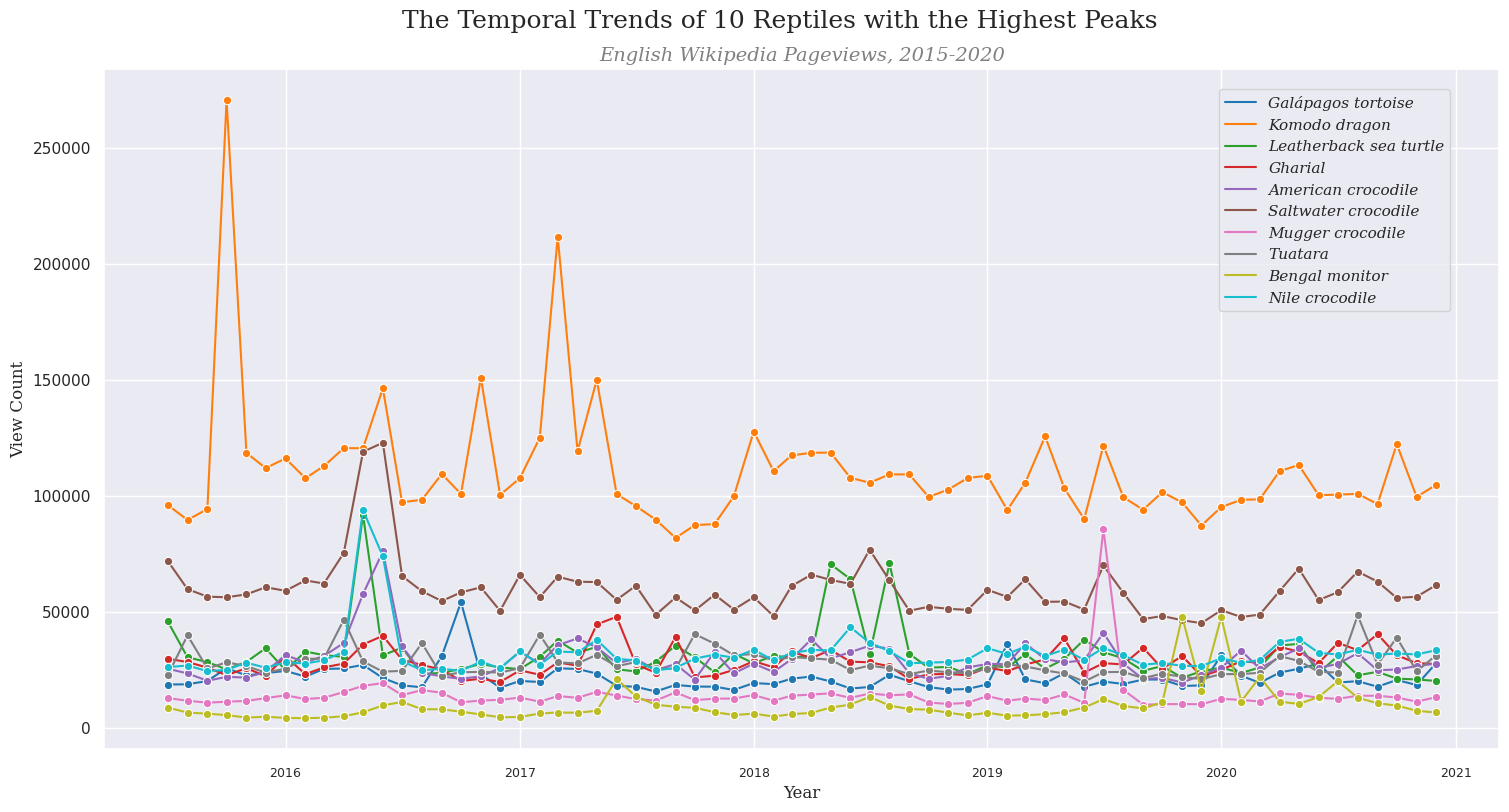

In [111]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
# Import packages
import cmasher as cmr

# Take 5 colors from rainforest in [0.15, 0.85] range in HEX
colors = cmr.take_cmap_colors('tab10', 
                              10, 
                              cmap_range=(0.02, .98), 
                              return_fmt='hex')

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(18,8.5)})
ax = sns.lineplot(
    x = 'datetime',
    y = 'views',
    hue = 'title',
    data = alltimereps, # Change to topalltime or alltimepeaks
    marker = "o", 
    palette = colors
)

ax.set_xlabel('Year', fontsize=12, family = "Serif")
ax.set_ylabel('View Count', fontsize=12, family = "Serif")
#plt.figure(figsize=(15,6))

# Add suptitle above the title
plt.suptitle("The Temporal Trends of 10 Reptiles with the Highest Peaks\n", fontsize=18, family = 'Serif')
plt.subplots_adjust(top=0.91)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('English Wikipedia Pageviews, 2015-2020', fontsize = 14, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=11)

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 9, left = True)
ax.legend(bbox_to_anchor=(.965, 0.97), loc='upper right', borderaxespad=0, prop=font)
plt.savefig('figures/wiki10peaksreptiles.png', bbox_inches = 'tight')

In [44]:
year2020 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])].drop_duplicates("Month").sort_values("Month")
year2019 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])].drop_duplicates("Month").sort_values("Month")
year2018 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])].drop_duplicates("Month").sort_values("Month")
year2017 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])].drop_duplicates("Month").sort_values("Month")
year2016 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])].drop_duplicates("Month").sort_values("Month")

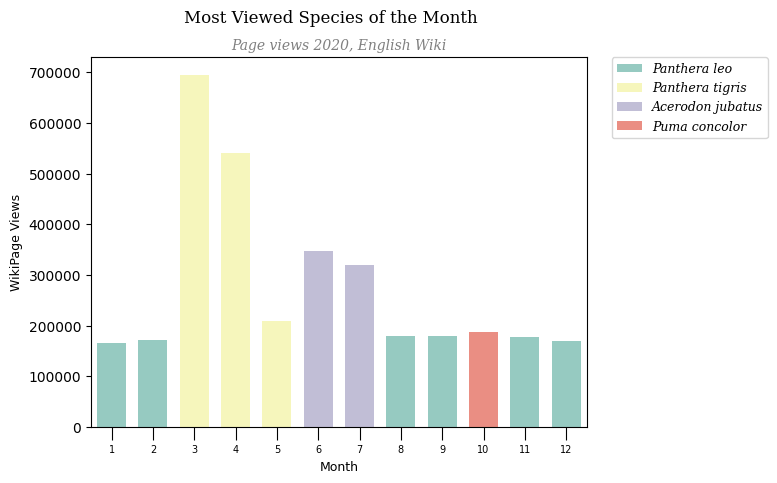

In [41]:
import seaborn as sns
import matplotlib.font_manager as font_manager

ax = sns.barplot(
    x = 'Month',
    y = 'views',
    hue = 'scientific_name',
    data = year2020, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Month', fontsize=9)
ax.set_ylabel('WikiPage Views', fontsize=9)


# Add suptitle above the title
plt.suptitle("Most Viewed Species of the Month\n", fontsize=12, family = 'Serif')

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2020, English Wiki', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=9)

ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
#plt.savefig('figures/2020_wikipageviews.png', bbox_inches = 'tight')

In [90]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Top 20 species in Wikipedia dataset
top20 = wiki.groupby(['title', 'scientific_name'])['views'].sum().nlargest(20).reset_index()

# Merge with the CITES infoset
top20= top20.merge(cites1, on = 'scientific_name', how = 'left').drop_duplicates().reset_index(drop=True)

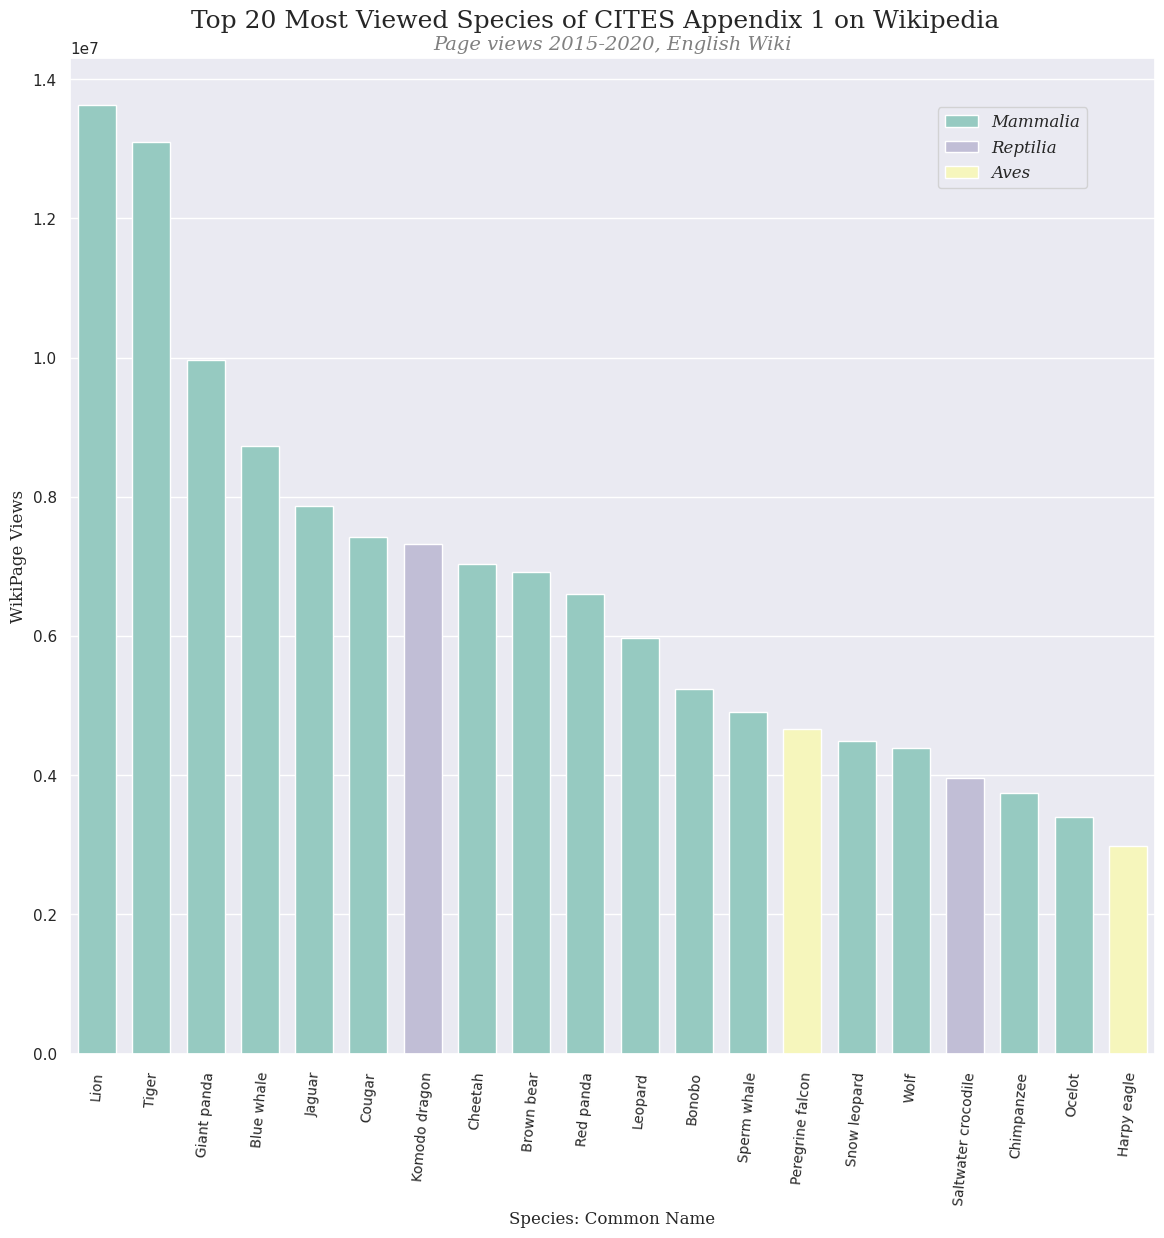

In [168]:
import seaborn as sns
palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}

ax = sns.barplot(
    x = 'title',
    y = 'views',
    hue = 'Class',
    data = top20, 
    width = 0.7, palette = palette, dodge = False
)
ax.set_xlabel('Species: Common Name', fontsize=12, family = "Serif")
ax.set_ylabel('WikiPage Views', fontsize=12, family = "Serif")


# Add suptitle above the title
plt.suptitle("Top 20 Most Viewed Species of CITES Appendix 1 on Wikipedia\n", fontsize=18, family= 'Serif')
plt.subplots_adjust(top=0.94)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2015-2020, English Wiki', fontsize = 14, color="grey", style='italic', family = 'Serif')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 10, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/top_20_species_wiki.png', bbox_inches = 'tight')

### Google Hits 

In [164]:
#google = pd.read_csv("csv/google_hits_species.csv", sep = ";")
#google = google.drop_duplicates().reset_index(drop = True)
top20google = speciesinfo.nlargest(columns = "hits_renew", n = 20)

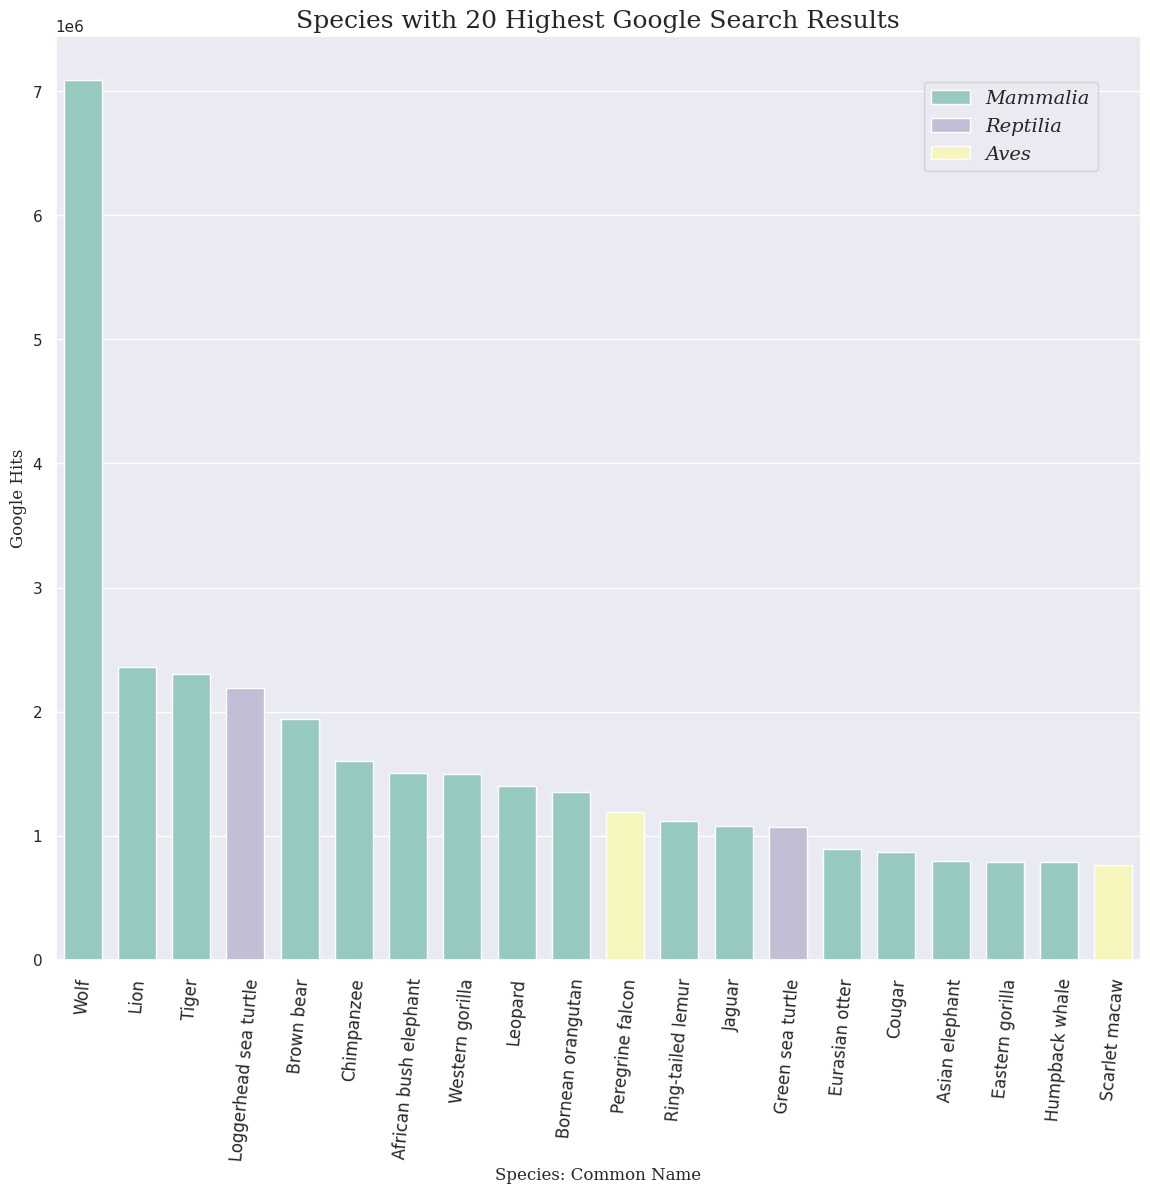

In [170]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

palette = {"Mammalia": "#8dd3c7", "Aves": "#ffffb3", "Reptilia": "#bebada"}

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})
ax = sns.barplot(
    x = 'title',
    y = 'hits_renew',
    hue = 'Class',
    data = top20google, 
    width = 0.7, 
    palette = palette, 
    dodge = False
)

ax.set_xlabel('Species: Common Name', fontsize=12, family = "Serif")
ax.set_ylabel('Google Hits', fontsize=12, family = "Serif")
#ax.set_yscale('log')


# Add suptitle above the title
plt.title("Species with 20 Highest Google Search Results", fontsize=18, family = 'Serif')

# Add title
#ax.set_title('Search Term included "Charismatic"', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=14)

ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 12, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/top_20_species_google.png', bbox_inches = 'tight')